In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# read dataset
df = pd.read_csv("dehydration_estimation.csv")
df

,id,age [years],height [cm],running speed [km/h],running interval,weight measured using Kern DE 150K2D [kg],weight measured using InBody 720 [kg],total body water using InBody 720 [l],impedance right arm at 1000kHz [Ohm],impedance left arm at 1000kHz [Ohm],...,temperature lower leg [degree C],sweat chloride [mmol/l],sweat osmolality [mmol/kg],salivary amylase [units/l],salivary chloride [mmol/l],salivary cortisol [ng/ml],salivary cortisone [ng/ml],salivary osmolality [mmol/kg],salivary potassium [mmol/l],salivary protein concentration [mg/l]
0,1,29.0,190.0,8.0,0,85.515,85.90,54.0,231.27,232.63,...,31.9,NaN,NaN,NaN,28.0,NaN,NaN,76.0,NaN,576.8
1,1,NaN,NaN,NaN,1,85.275,85.56,53.7,234.75,240.08,...,31.3,56.0,146.0,NaN,29.0,NaN,NaN,78.0,NaN,544.1
2,1,NaN,NaN,NaN,2,84.895,85.32,54.0,230.81,233.95,...,31.2,55.0,134.0,111700.0,35.0,1.240,11.80,84.0,37.0,537.3
3,1,NaN,NaN,NaN,3,84.540,84.90,54.0,231.96,236.32,...,30.9,53.0,123.0,NaN,38.0,0.947,10.60,95.0,38.0,595.6
4,1,NaN,NaN,NaN,4,84.185,84.48,53.9,227.03,232.07,...,31.7,36.0,185.0,154110.0,37.0,0.727,9.64,91.0,32.0,541.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,10,NaN,NaN,NaN,4,54.756,55.10,36.5,220.02,214.26,...,33.0,46.0,139.0,542510.0,31.0,1.620,15.10,94.0,45.0,779.9
86,10,NaN,NaN,NaN,5,54.522,54.92,36.7,222.31,210.66,...,32.8,NaN,164.0,777120.0,37.0,3.720,21.30,144.0,50.0,1202.9
87,10,NaN,NaN,NaN,6,54.302,54.64,36.4,220.09,215.22,...,32.6,51.0,160.0,777000.0,43.0,4.560,26.30,147.0,55.0,1269.2
88,10,NaN,NaN,NaN,7,54.070,54.48,36.6,220.29,215.13,...,32.4,60.0,277.0,858310.0,40.0,7.430,29.60,146.0,55.0,1367.1


In [31]:
# simple preprocessing (remove fields not suitable for our app)

# df = df.drop(["id", "running speed [km/h]", "running interval", "weight measured using Kern DE 150K2D [kg]", "impedance right arm at 1000kHz [Ohm]", "impedance left arm at 1000kHz [Ohm]", "impedance trunk at 1000kHz [Ohm]", "impedance right leg at 1000kHz [Ohm]", "impedance left leg at 1000kHz [Ohm]"], axis=1)
df = df.drop(["id", "running speed [km/h]", "running interval", "weight measured using Kern DE 150K2D [kg]", "impedance right arm at 1000kHz [Ohm]", "impedance left arm at 1000kHz [Ohm]", "impedance trunk at 1000kHz [Ohm]", "impedance right leg at 1000kHz [Ohm]", "impedance left leg at 1000kHz [Ohm]"], axis=1)
df = df.drop(["temperature ear [degree C]", "temperature left foot [degree C]", "temperature right foot [degree C]", "temperature chest [degree C]", "temperature back [degree C]", "temperature upper leg [degree C]", "temperature lower leg [degree C]"], axis=1)
df = df.iloc[:, :8]
df['hand_temperature_average'] = df[['temperature left hand [degree C]', 'temperature right hand [degree C]']].mean(axis=1)
df = df.drop(columns=['temperature left hand [degree C]', 'temperature right hand [degree C]'])
df['arm_temperature_average'] = df[['temperature upper arm [degree C]', 'temperature lower arm [degree C]']].mean(axis=1)
df = df.drop(columns=['temperature upper arm [degree C]', 'temperature lower arm [degree C]'])
df

,age [years],height [cm],weight measured using InBody 720 [kg],total body water using InBody 720 [l],hand_temperature_average,arm_temperature_average
0,29.0,190.0,85.90,54.0,32.25,32.10
1,NaN,NaN,85.56,53.7,30.95,31.15
2,NaN,NaN,85.32,54.0,31.10,29.90
3,NaN,NaN,84.90,54.0,30.55,29.95
4,NaN,NaN,84.48,53.9,32.35,31.05
...,...,...,...,...,...,...
85,NaN,NaN,55.10,36.5,35.15,33.25
86,NaN,NaN,54.92,36.7,35.15,33.30
87,NaN,NaN,54.64,36.4,35.00,33.00
88,NaN,NaN,54.48,36.6,35.15,32.35


In [32]:
from sklearn.impute import KNNImputer

# Deal w/ missing values (KNN Imputer)
imputer = KNNImputer(n_neighbors=3)

df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [33]:
# Split dataset based on what to predict vs. what we use to predict
X = df.drop(["total body water using InBody 720 [l]"], axis=1)
y = df["total body water using InBody 720 [l]"]

In [34]:
y.head()

0    54.0
1    53.7
2    54.0
3    54.0
4    53.9
Name: total body water using InBody 720 [l], dtype: float64

In [35]:
from sklearn import model_selection

# data split - 20% test, 80% train
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state=42, shuffle=True)

**Linear Regression Model**

In [36]:
from sklearn.linear_model import LinearRegression

# Initialize LinearRegression model
regr = LinearRegression()
regr.fit(X_train, y_train)

regresor_pred = regr.predict(X_test)

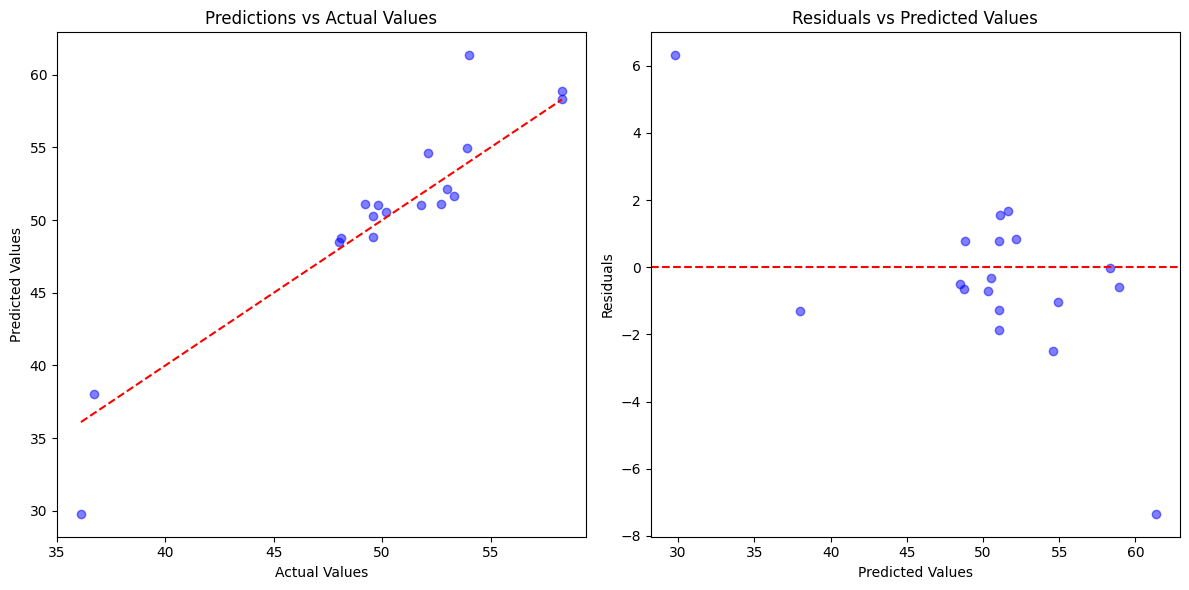

In [37]:
plt.figure(figsize=(12, 6))

# Scatter plot for predictions vs actual values
plt.subplot(1, 2, 1)
plt.scatter(y_test, regresor_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')

# Residual Plot
plt.subplot(1, 2, 2)
residuals = y_test - regresor_pred
plt.scatter(regresor_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

plt.tight_layout()
plt.show()

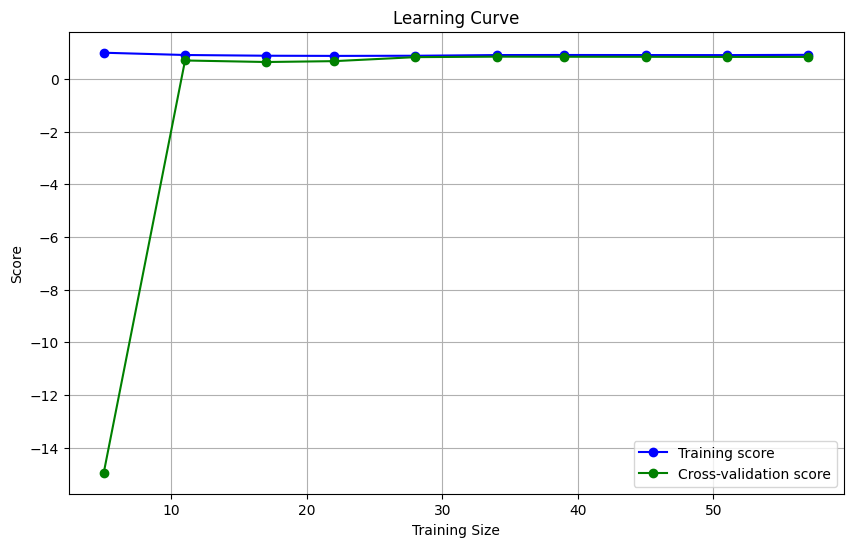

In [38]:
from sklearn.model_selection import learning_curve
import numpy as np

# Calc. Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    LinearRegression(), X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='green', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

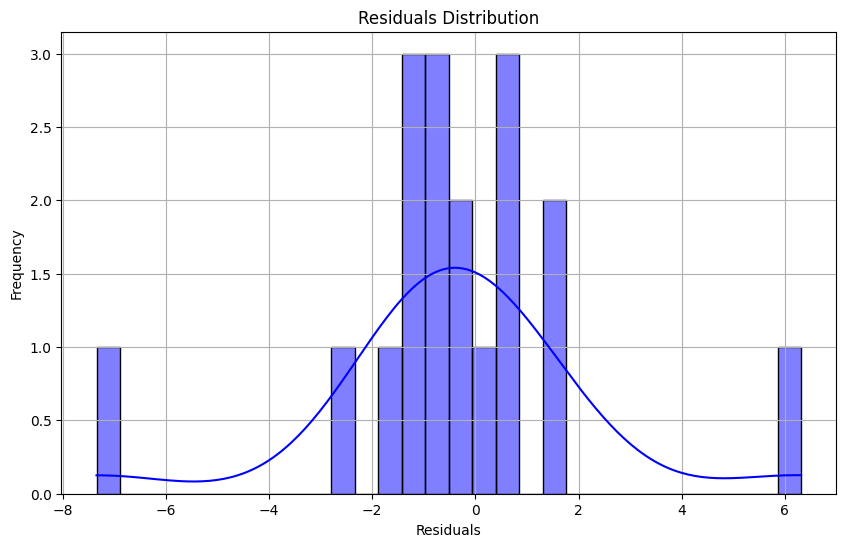

In [39]:
import seaborn as sns

# Residuals Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue', bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.grid()
plt.show()

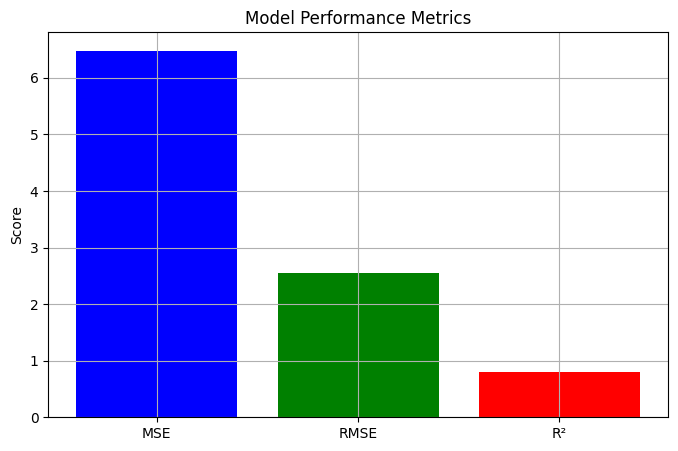

In [40]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate performance metrics
mse = mean_squared_error(y_test, regresor_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, regresor_pred)

# Plot Performance Metrics
metrics = {'MSE': mse, 'RMSE': rmse, 'R²': r2}
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red'])
plt.ylabel('Score')
plt.title('Model Performance Metrics')
plt.grid()
plt.show()

In [41]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

In [42]:
# For Linear Regression Model
print(mean_absolute_error(y_test, regresor_pred))
print(mean_squared_error(y_test, regresor_pred))
print(median_absolute_error(y_test, regresor_pred))
print(r2_score(y_test, regresor_pred))
print(explained_variance_score(y_test, regresor_pred))

1.6688056356793664
6.481756399619983
0.9404373091819487
0.7993066747313093
0.8029546824711746


**XGBoost**

In [43]:
from sklearn.kernel_ridge import KernelRidge

# Kernel Ridge Algorithm
kernel = KernelRidge()
kernel.fit(X_train, y_train)

kernel_pred = kernel.predict(X_test)

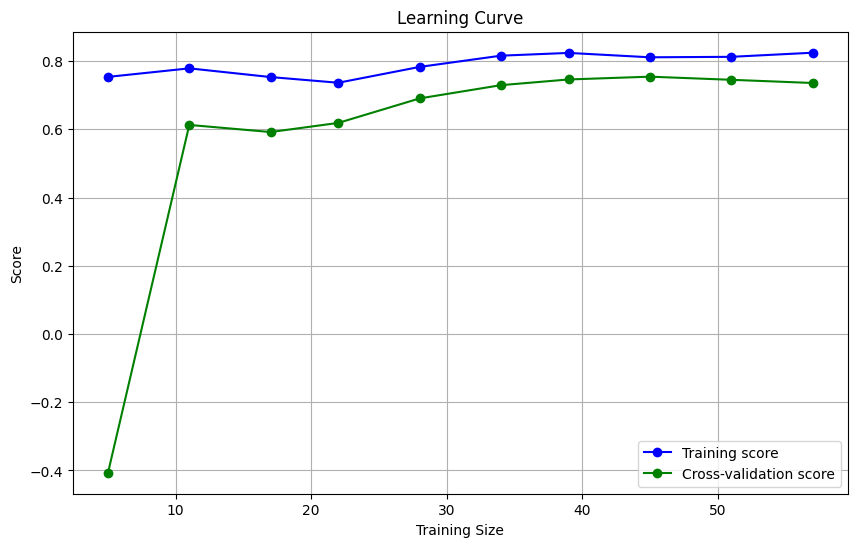

In [44]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    KernelRidge(), X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='green', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

In [45]:
print(mean_absolute_error(y_test, kernel_pred))
print(mean_squared_error(y_test, kernel_pred))
print(median_absolute_error(y_test, kernel_pred))
print(r2_score(y_test, kernel_pred))
print(explained_variance_score(y_test, kernel_pred))

1.6774102420002839
3.9249969972747234
1.6761496027116678
0.8784711040515386
0.8787596108952344


**ElasticNet**

In [46]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet()
elastic.fit(X_train, y_train)

elastic_pred = elastic.predict(X_test)

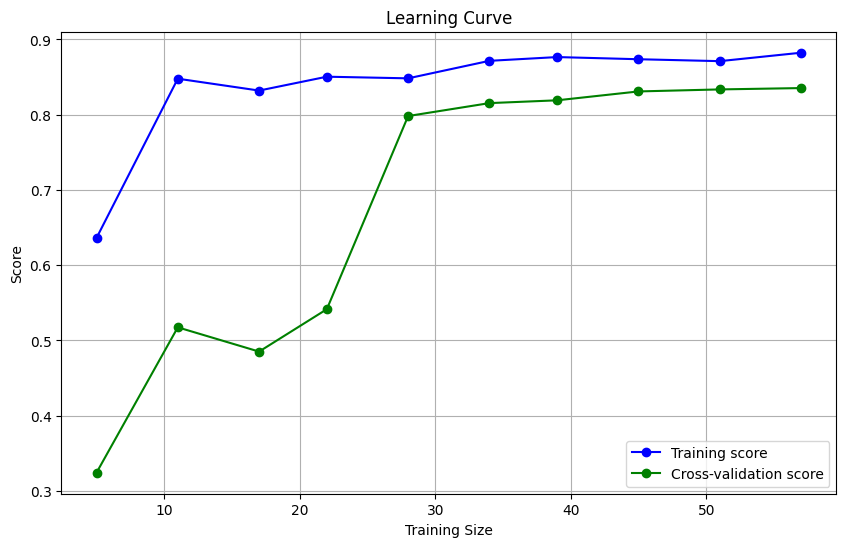

In [19]:
train_sizes, train_scores, test_scores = learning_curve(
    ElasticNet(), X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='green', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

In [20]:
print(mean_absolute_error(y_test, elastic_pred))
print(mean_squared_error(y_test, elastic_pred))
print(median_absolute_error(y_test, elastic_pred))
print(r2_score(y_test, elastic_pred))
print(explained_variance_score(y_test, elastic_pred))

1.7517310586186785
5.333697068956695
1.5195178482322014
0.8348538058592349
0.8356371160108529


In [47]:
from sklearn.linear_model import BayesianRidge

bayesian = BayesianRidge()
bayesian.fit(X_train, y_train)

bayesian_pred = bayesian.predict(X_test)

print(mean_absolute_error(y_test, bayesian_pred))
print(mean_squared_error(y_test, bayesian_pred))
print(median_absolute_error(y_test, bayesian_pred))
print(r2_score(y_test, bayesian_pred))
print(explained_variance_score(y_test, bayesian_pred))

1.6646261546797132
6.273749092238765
1.0608849951252246
0.8057471633311232
0.808441576771249


**Ensemble Model**

In [48]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import StackingRegressor
from sklearn.kernel_ridge import KernelRidge

# Base models
base_models = [
    ('linear', LinearRegression()),
    ('kernel', KernelRidge()),
    ('bayesian', BayesianRidge())
]

# Stacked ensembled model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())

# Train stacking model
stacking_model.fit(X_train, y_train)

# Predict with stacking model
predictions = stacking_model.predict(X_test)

print(mean_absolute_error(y_test, predictions))
print(mean_squared_error(y_test, predictions))
print(median_absolute_error(y_test, predictions))
print(r2_score(y_test, predictions))
print(explained_variance_score(y_test, predictions))

1.634648245989852
5.969707048907891
1.018652095802512
0.8151611562268046
0.8172265045915812


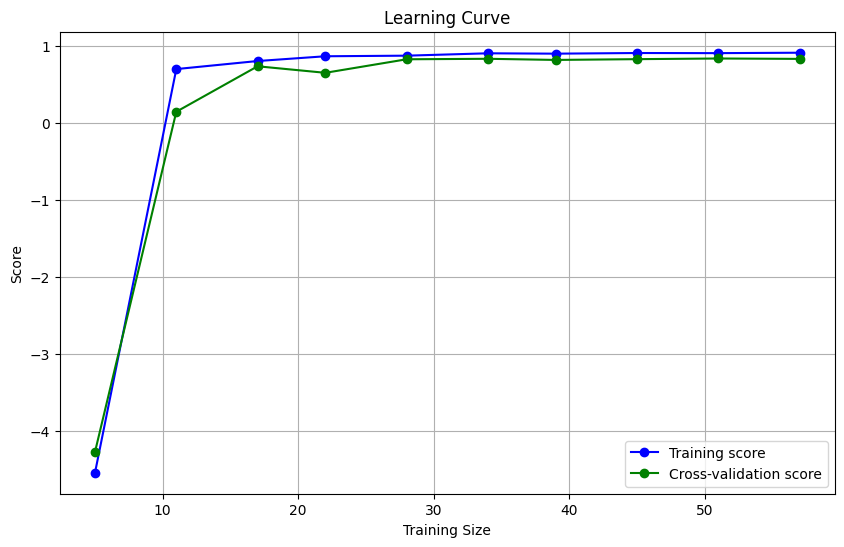

In [49]:
train_sizes, train_scores, test_scores = learning_curve(
    stacking_model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='green', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

In [50]:
import pickle

# Save model. 
with open('../server/dehydration_estimation_model.pkl','wb') as f:
    pickle.dump(stacking_model,f)

In [51]:
df.columns.values

array(['age [years]', 'height [cm]',
       'weight measured using InBody 720 [kg]',
       'total body water using InBody 720 [l]',
       'hand_temperature_average', 'arm_temperature_average'],
      dtype=object)